<a href="https://colab.research.google.com/github/vbulycheva/notebooks/blob/master/bubbles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode
import collections


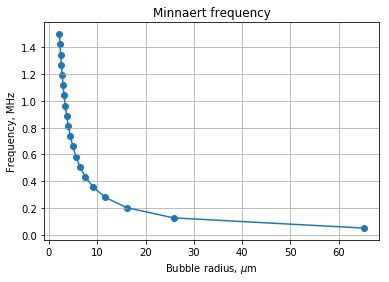

In [27]:
###################################
##   Minnaert frequency graph   ###
###################################

freqs = np.linspace(0.05,1.5, num = 20) # in MHz
rad = 3.26 / freqs # in um
## 3.26 for water under normal ambient pressure https://en.wikipedia.org/wiki/Minnaert_resonance

plt.scatter(rad, freqs)
plt.plot(rad, freqs)
plt.title('Minnaert frequency')
plt.ylabel('Frequency, MHz')
plt.xlabel(r'Bubble radius, $\mu$m')
plt.grid(True)
plt.show()

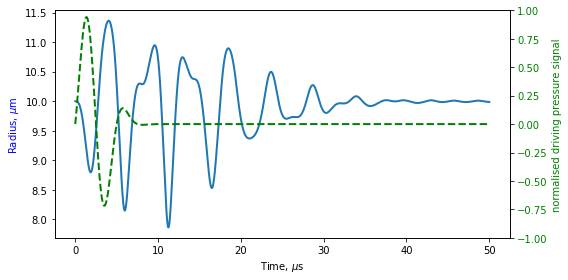

In [28]:
##########################
##   Marmottant model   ##
##########################

# Governs lipid shell bubble dynamics under ultrasound
# https://www-liphy.ujf-grenoble.fr/pagesperso/marmottant/Philippe_Marmottant/Publications_files/Marmottant2005_JASACoatedBubble.pdf


################################################################################

##   Parameters of the model   ##

# General parameters #

v_0 = 0.0      # initial interface speed, m/s
p_0 = 101325.  # ambient pressure = p_inf, Pa
pvap = 0       # vapour pressure, Pa
rho = 1.e3     # water density, kg/m3
nu = 1.e-3     # water viscosity, Pa.s
c = 1480.      # speed of sound in water, m/s

# Model parameters #

bubble_model = collections.namedtuple('bubble_model', ['sigma_0', 'sigma_w', 'kappa', 'k_s', 'chi'])

# sigma_0: initial shell surface tension, correlated r_0/r_buckling, N/m
# sigma_w: water surface tension, N/m 
# kappa: polytropic index
# k_s: dilatational viscosity, kg/s
# chi: shell elasticity, N/m

marmottant = bubble_model(sigma_0 = 0., sigma_w = 0.1, kappa = 1.095, k_s = 15.e-9, chi = 1.)
# from https://www-liphy.ujf-grenoble.fr/pagesperso/marmottant/Philippe_Marmottant/Publications_files/Marmottant2005_JASACoatedBubble.pdf
overvelde = bubble_model(sigma_0 = 0.02, sigma_w = 0.0728, kappa = 1.07, k_s = 6.e-9, chi = 2.5)
# from https://www.ncbi.nlm.nih.gov/pubmed/21030140

par = marmottant # this parameter will be used in the equation
# par = []       # model parameters can be input manually here

### US conditions ####

r_0 = 10.e-6        # initial bubble RADIUS, m
amp = p_0 * 0.4    # amplitude of acoustic pressure, ratio to ambient pressure
fr = 0.2e6         # acoustic driving frequency, Hz 
n_cycles = 1.      # number of cycles in US wave


################################################################################

# Dimensionalized equation:
# r * r''+ r' * r' * 3/2 = a[0] * r ** (- 3 * k) * (1 - a[1] * r') - a[2] - sigma * a[3]  - 
# - a[4] * r'/r - a[5] * r' / r**2 - a[6]* p_ac(t) 

# Coefficients in equation
a = np.zeros(7)    # dimensionless coefficients
b = np.zeros(2)    # surface tension coefficients

a[0] = (p_0 - pvap + 2. * par.sigma_0 / r_0 ) / (rho * fr ** 2 * r_0 ** 2)      
a[1] = 3. * par.kappa * r_0 * fr / c
a[2] = p_0 / (rho * fr**2 * r_0**2)
a[3] = 2.  / (rho * fr**2 * r_0**3)
a[4] = 4. * nu / (rho * r_0**2 * fr)
a[5] = 4. * par.k_s /(rho * r_0**3 * fr)
a[6] = amp / (rho * r_0**2 * fr**2)

# Surface tension coefficients 
b[0] = r_0
b[1] = 0.5 * (par.sigma_w - par.sigma_0 )/ par.chi

### Solution ###

# define piecewise function for surface tension
def sigma_lin(r):
    if r < (1. + b[0]):
        #print r
        return 0.
    elif r > (1. + b[1]):
        return par.sigma_w
    else: 
        return par.sigma_0 + 2. * par.chi * (r - 1.)
    
def sigma_d(r):
    if (r > (1. + b[0])) and r < (1. + b[1]):
        return 2. * par.chi 
    else: 
        return 0.
      
## Acoustic driving signal window application. Options: rectangular, Gaussian, none ##

# Rectangular window. Sinusoidal signal applied for given number of sycles
def rect_window(time, cycles):
  if time < cycles:
    return 1.
  else:
    return 0.      
      
# Gaussian window. Sinusoidal signal applied for given number of sycles (mu = sigma = 2* number of cycles)
def gauss_window(time, cycles):
    return np.exp (-0.5 * ((time - 2 * cycles) / (2 * cycles)) **2) 
  

# dimensionalized initial conditions, shouldn't be modified      
y0, t0 = [1.0, 0.0], 0     

window = gauss_window # Choose type of the window here
# It can be gauss_window for Gaussian wrap, rect_window for a rectangular window, or 1. for no window

# equations for r,v
def f (t,y):
    return [y[1] , -1.5 * y[1] ** 2 / y[0] + a[0] * (1 - a[1] * y[1]) * y[0] ** (-3 * par.kappa - 1) - a[2] / y[0] - 
            a[3] * sigma_lin(y[0]) / y[0] ** 2 - a[4] * y[1] / y[0] ** 2 - a[5] * y[1] / y[0] ** 3 - a[6] * (np.sin(2. * np.pi * t)) * window(t, n_cycles)/ y[0]]

def jac (t,y):
    return [[0. , 1.] , [1.5 * y[1] ** 2 / y[0] ** 2 + a[0] * (1 - a[1] * y[1])* (- 3 * par.kappa - 1) * y[0] ** (- 3 * par.kappa - 2)  + a[2] / y[0] ** 2 + 
            2. * a[3] * sigma_lin(y[0]) / y[0] ** 3 - a[3] * sigma_d(y[0]) / y[0] ** 2 + 2. * a[4] * y[1] / y[0] ** 3 + 
                       3 * a[5] * y[1] / y[0] ** 4 + a[6] * np.sin(2. * np.pi * t) * np.exp (-0.5 * ((t  - 2 * 5.)/ 5.) ** 2 )  / y[0] ** 2, - 3. * y[1] /y[0] - 
            a[0] * a[1] * y[0] ** (-3 * par.kappa - 1) - a[4] * y[0] ** 2 - a[5] / y[0] ** 3]]

  
res = []
der = []

r = ode(f, jac).set_integrator('vode', method='BDF')    
# available integrators are 'vode', 'zvode', 'Isoda', 'dopri5', 'dop853'. Method depends on integrator 
# more info here https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html
r.set_initial_value(y0, t0)
t1 = 10         # dimensionless time, relatively to US frequency 
dt = 0.001      # integration step
while r.successful() and r.t < t1:
    res.append (r.integrate(r.t+dt)[0])
    der.append (r.integrate(r.t+dt)[1])
    
################################################################################    

### Results ###

#  Back to dimensions

tt = np.linspace(0, t1 * 10.**6 / fr, len(res))   # time, Us
#rr, vv = [np.zeros(len(res)), np.zeros(len(res))]
rr  = np.asarray(res) * r_0 * 10.**6  # radius, Um
vv = np.asarray(der) * r_0 / fr                # interface velocity, m/s

# Plot: radial dynamics in time + pressure 

def plot_dynamics (tt,rr, ymin=None):
  plt.figure(figsize=[8,4])
  ax1a = plt.axes()
  ax1a.plot(tt, rr, lw=2)
  if ymin is not None: ax1a.set_ylim(ymin=ymin)
  ax1a.set_ylabel(r'Radius, $\mu$m', color = 'b')
  ax1a.set_xlabel(r'Time, $\mu$s')
  #plt.legend(loc='upper right')
  ax1b=ax1a.twinx()
  ax1b.plot(tt, np.sin(2. * np.pi * fr * 10.**-6 * tt) * window(tt,n_cycles) ,'g--',lw=2) 
  ax1b.set_ylabel('normalised driving pressure signal',color='g')
  ax1b.set_ylim([-1,1])
  for tl in ax1b.get_yticklabels():
      tl.set_color('g')
  plt.tight_layout()
  return

plot_dynamics(tt,rr)
# plt.savefig('dynamics.png', dpi=240,bbox_inches='tight')

#* np.exp (-0.5 * ((t  - 2 * 5.)/ 5.) ** 2 )  added to sin - check the deriv. part